In [4]:
import ScraperFC as sfc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
from mplsoccer import FontManager, add_image
from mplsoccer import Pitch

from PIL import Image
import os

font_path = "../LigaArgStats/assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("soc_base.mplstyle")
plt.rcParams['font.family'] = 'Karla'

In [5]:
sofascore = sfc.Sofascore()

In [10]:
df = sofascore.scrape_league_stats('2023', 'Colombia Primera A Clausura', accumulation='total', selected_positions=['Midfielders'])
df_p90 = sofascore.scrape_league_stats('2023', 'Colombia Primera A Clausura', accumulation='per90', selected_positions=['Midfielders'])

End of the pages
End of the pages


In [38]:
df_plot = df_p90.merge(df[['player', 'minutesPlayed']], on='player', suffixes=['_x', ''])

In [15]:
df_plot.columns

Index(['goals', 'yellowCards', 'redCards', 'groundDuelsWon',
       'groundDuelsWonPercentage', 'aerialDuelsWon',
       'aerialDuelsWonPercentage', 'successfulDribbles',
       'successfulDribblesPercentage', 'tackles', 'assists',
       'accuratePassesPercentage', 'totalDuelsWon', 'totalDuelsWonPercentage',
       'minutesPlayed_x', 'wasFouled', 'fouls', 'dispossessed', 'appearances',
       'saves', 'savedShotsFromInsideTheBox', 'savedShotsFromOutsideTheBox',
       'goalsConcededInsideTheBox', 'goalsConcededOutsideTheBox', 'highClaims',
       'successfulRunsOut', 'punches', 'runsOut', 'accurateFinalThirdPasses',
       'bigChancesCreated', 'accuratePasses', 'keyPasses', 'accurateCrosses',
       'accurateCrossesPercentage', 'accurateLongBalls',
       'accurateLongBallsPercentage', 'interceptions', 'clearances',
       'dribbledPast', 'bigChancesMissed', 'totalShots', 'shotsOnTarget',
       'blockedShots', 'goalConversionPercentage', 'hitWoodwork', 'offsides',
       'expectedGoa

In [39]:
col1 = 'fouls'
col2 = 'wasFouled'
df_plot = df_plot[['player', 'minutesPlayed',col1, col2]]

In [22]:
df_plot

,player,minutesPlayed,keyPasses,shotsOnTarget
0,Edwin Cardona,1219,3.69,1.03
1,Yeison Guzmán,1893,3.00,1.09
2,Edwuin Cetré,1825,2.27,1.48
3,Johan Rojas,1150,2.27,1.49
4,Luis Daniel González,1583,2.62,1.14
...,...,...,...,...
231,Luis Renteria,17,0.00,0.00
232,Jose Hernandez Chavez,13,0.00,0.00
233,Jose Ramirez Agudelo,10,0.00,0.00
234,Juan Aristizbal,1,0.00,0.00


In [35]:
df_plot.describe()

,minutesPlayed,fouls,wasFouled
count,236.000000,236.000000,236.000000
mean,727.546610,1.400085,1.441525
std,527.986712,1.084353,1.268877
min,1.000000,0.000000,0.000000
25%,279.000000,0.827500,0.717500
50%,647.000000,1.215000,1.175000
75%,1176.250000,1.865000,1.760000
max,1931.000000,9.000000,10.000000


In [40]:
limite1 = .5
limite2 = .5
minutos = 400
df_plot = df_plot[(df_plot[col1] > limite1) & (df_plot[col2] > limite2) & (df_plot['minutesPlayed'] > minutos)]

In [41]:
df_plot

,player,minutesPlayed,fouls,wasFouled
0,Edwin Cardona,1219,1.18,2.07
1,Yeison Guzmán,1893,1.00,1.47
3,Johan Rojas,1150,1.80,0.55
4,Luis Daniel González,1583,0.68,1.25
5,Pablo Lima,1701,1.16,0.69
...,...,...,...,...
206,Miguel Monsalve,417,1.94,1.73
207,Ewil Murillo,858,2.62,1.26
208,Fabián Mosquera,474,1.33,0.95
210,Bladimir Angulo,667,2.29,0.54


In [42]:
df_plot['zscore'] = stats.zscore(df_plot[col1])*.4 + stats.zscore(abs(df_plot[col2]))*.6
df_plot['annotated'] = [True if x > df_plot['zscore'].quantile(.85) else False for x in df_plot['zscore']]

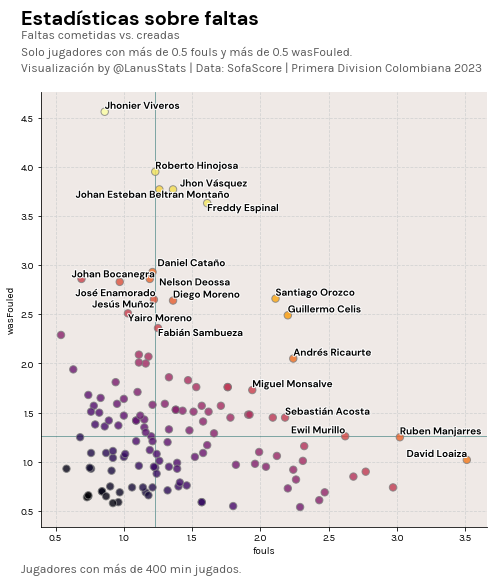

In [43]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')
fig.set_facecolor('white')

ax.scatter(
    df_plot[col1], df_plot[col2], 
    c=df_plot['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0.8)

texts = []
annotated_df = df_plot[df_plot['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df[col1].iloc[index], y=annotated_df[col2].iloc[index],
            s=f"{annotated_df['player'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.set_ylabel(f'{col2}')
ax.set_xlabel(f'{col1}')
ax.axvline(df_plot[col1].median(), lw=.8, alpha=.7)
ax.axhline(df_plot[col2].median(), lw=.8, alpha=.7)


fig_text(
    x = 0.09, y = .99, 
    s = "Estadísticas sobre faltas",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = f"Faltas cometidas vs. creadas\nSolo jugadores con más de {limite1} {col1} y más de {limite2} {col2}.\nVisualización by @LanusStats | Data: SofaScore | Primera Division Colombiana 2023",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

fig_text(
    x = 0.09, y = 0.04, 
    s = f"Jugadores con más de {minutos} min jugados.",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

plt.savefig(
	f"{col1.replace('/', '_')}_{col2.replace('/', '_')}.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)